In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

#MISSING DEPENDENCY inspect NEEDED TO IMPORT

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# create inspector and connect it to the engine
inspector = inspect(engine)

In [6]:
# collect the names of the tables within the database
inspector.get_table_names()

['measurement', 'station']

In [7]:
# use inspector to print column names and types
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c['name'], c['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# print first 5 rows for measurement table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c['type']) 

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# print first 5 rows for station table
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date = recent_date.date
print(recent_date)

2017-08-23


A year ago was: 2016-08-23


Text(0.5, 1.0, 'Percipitation From 8/23/2016 - 8/23/2017')

<Figure size 432x432 with 0 Axes>

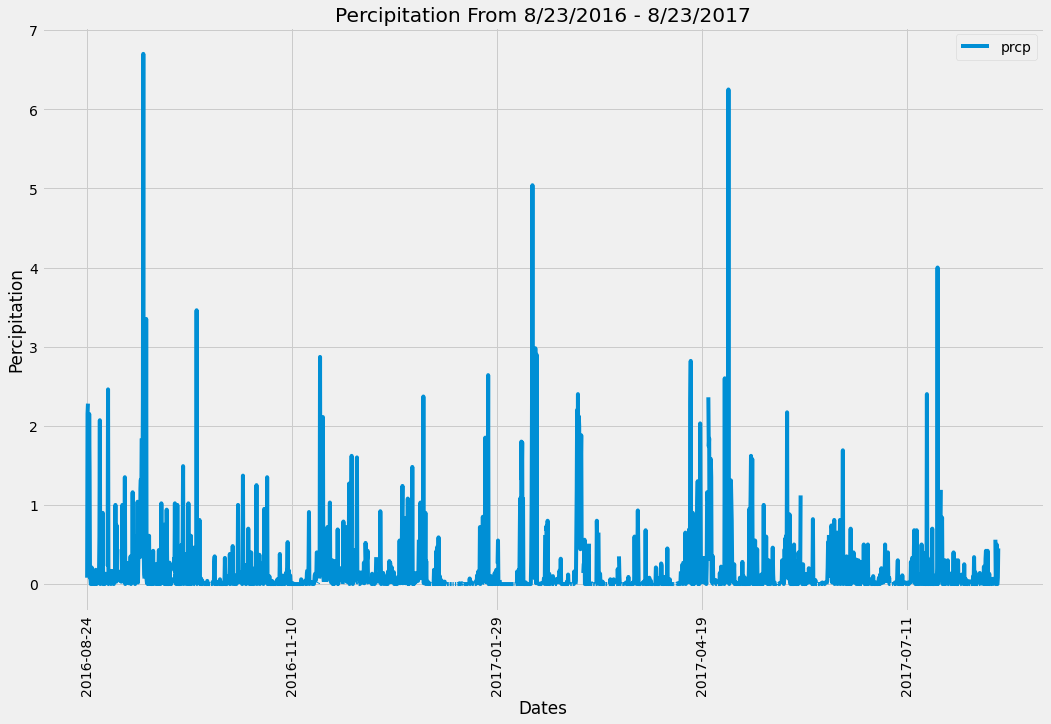

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

    
# Calculate the date one year from the last date in data set.
yr_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f'A year ago was: {yr_ago}')

# Perform a query to retrieve the data and precipitation scores
twelve_month_prcp = session.query(measurement.date, measurement.prcp).\
filter(measurement.date > yr_ago).\
order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame(twelve_month_prcp, columns=['date', 'prcp'])
data_df.set_index('date', inplace=True)
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
fig1 = plt.figure(figsize=(6,6))
data_df.plot(y='prcp', rot=90, figsize =(16, 10))
plt.xlabel('Dates')
plt.ylabel('Percipitation')
plt.title('Percipitation From 8/23/2016 - 8/23/2017')


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(measurement).group_by(measurement.station).count()
print(f"Total stations: {total_stations}")

Total stations: 9


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

print(active_stations)
print(f"This is the most active station: {active_stations[0][0]} and count: {active_stations[0][1]}")

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
This is the most active station: USC00519281 and count: 2772


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]
temp_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == most_active).all()

print(f" min: {temp_stats[0][0]}, max: {temp_stats[0][1]}, avg: {temp_stats[0][2]}")

 min: 54.0, max: 85.0, avg: 71.66378066378067


,station,date,temperature
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0


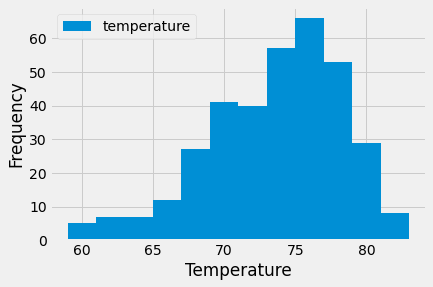

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_twelve_months = session.query(measurement.station, measurement.date, measurement.tobs).\
    filter(measurement.station == most_active).\
    filter(measurement.date >= yr_ago).\
    order_by(measurement.date).all()

temp_df = pd.DataFrame(temp_twelve_months)
temp_df.columns = ['station', 'date', 'temperature']

temp_df.plot(kind='hist', bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

temp_df.head()

# Close session

In [22]:
# Close Session
session.close()

# Step 2 - Climate App

In [23]:
#Code in app.py